<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1a_sgd_reglin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal mediante descenso por gradiente
En esta libreta programaremos y evaluaremos el algoritmo de descenso por gradiente para regresión lineal.

In [1]:
import numpy as np
np.random.seed(42) # por reproducibilidad

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as ecm
from sklearn.model_selection import train_test_split

## Conjunto de datos
Posteriormente cargamos los datos de GPAs de alumnos de licenciatura (fuente: http://onlinestatbook.com/2/case_studies/sat.html). Usamos sólo el atributo Computer Science GPA (columna `comp_GPA`) como regresor para el University GPA (columna `univ_GPA`).

In [2]:
sat = pd.read_csv('http://onlinestatbook.com/2/case_studies/data/sat.txt', sep=' ')

X = sat.comp_GPA.to_numpy()[:, np.newaxis]
y = sat.univ_GPA.to_numpy()[:, np.newaxis]

Dividimos  aleatoriamente el conjunto de datos en 80% para entrenamiento y 20% para validación. Para eso usaremos la funcion `train_test_split` de scikit-learn.

In [3]:
X_ent, X_valid, y_ent, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X_rango = np.arange(2.0, 4.0, 0.01)[:, np.newaxis].T 

## Descenso por gradiente
Vamos a entrenar un modelo de regresión lineal usando descenso por gradiente. En particular, buscaremos minimizar la pérdida de suma de errores cuadráticos, la cual definimos de la siguiente manera:
$$
ECM(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{2} \sum_{i = 1} ^n \left(\hat{y^{(i)}} - y^{(i)}\right)^2
$$

El gradiente de esta función de pérdida respecto a los parámetros $\mathbf{w} \in \mathbb{R}^d$ y $b \in \mathbb{R}$ está dado por

$$
\nabla ECM(\mathbf{y}, \hat{\mathbf{y}}) = \left[\frac{\partial ECM(\mathbf{y}, \hat{\mathbf{y}})}{\partial b}, \frac{\partial ECM(\mathbf{y}, \hat{\mathbf{y}})}{\partial w_1}, \cdots, \frac{\partial ECM(\mathbf{y}, \hat{\mathbf{y}})}{\partial w_d}\right]
$$

donde

$$
\begin{align*}
\frac{\partial ECM(\mathbf{y}, \hat{\mathbf{y}})}{\partial w_j} & = \sum_{i=1}^n \left[ \left(\hat{y}^{(i)} - y^{(i)}\right) \cdot x_j^{(i)} \right]\\
\frac{\partial ECM(\mathbf{y}, \hat{\mathbf{y}})}{\partial b} & = \sum_{i=1}^n \left(\hat{y}^{(i)} - y^{(i)}\right)
\end{align*}
$$

In [4]:
def descenso_gradiente(X, y, n_epocas = 10, tasa = 0.001):
  hist = np.zeros(n_epocas)
  
  # Inicializamos los pesos con números aleatorios
  w = np.random.rand(X.shape[1], 1, )
  # Inicializamos el sesgo con 0
  b = np.zeros((1, 1))
  for e in range(n_epocas):
    # Obtenemos predicciones con parámetro actual
    y_hat =  X @ w + b

    # Monitoreamos la pérdida 
    hist[e] = ecm(y, y_hat)

    # Actualizamos parámetro
    w -= tasa * X.T @ (y_hat - y)
    b -= tasa * (y_hat - y).sum()

  return w, b, hist

En el entrenamiento de redes neuronales profundas es común usar aproximaciones estocásticas del descenso por gradiente (o variaciones). Estas aproximaciones estiman $\nabla \mathcal{L}(\boldsymbol{\theta}^{[t]})$ y actualizan los parámetros (pesos y sesgos) usando un minilote $\mathcal{B}$ de ejemplos (en lugar de todo el conjunto) de entrenamiento, donde $\vert \mathcal{B} \vert$ es un hiperparámetro. Una estrategia para generar los lotes es dividir y ordenar aleatoriamente el conjunto de $n$ ejemplos de entrenamiento en $k$ minilotes ($\vert \mathcal{B} \vert \times k \approx n$) e ir tomando lotes consecutivos hasta pasar por todo el conjunto. Aquí una época ocurre cada vez que se han considerado los $k$ minilotes. Para poder entrenar nuestro modelo usando descenso por gradiente estocástico es conveniente definir un generador de lotes.

In [5]:
def genera_lotes(X, y, t_lote):
  n = X.shape[0] 
  n_lotes = int(np.floor(n / t_lote)) # Se calcula el número de lotes
                                      # Se descartan ejemplos posteriores
                                      # al último lote, en caso de haber
  perm = np.random.permutation(n)
  Xperm = X[perm]
  yperm = y[perm]
  for l in range(n_lotes):
    Xlote = Xperm[l * t_lote: (l + 1) * t_lote]
    ylote = yperm[l * t_lote: (l + 1) * t_lote]
    yield l, Xlote, ylote

Definimos una función para entrenar nuestro modelo usando el descenso por gradiente estocástico que emplea el generador de lotes.  

In [6]:
def descenso_gradiente_estocastico(X, y, n_epocas = 10, t_lote = 10, tasa = 0.001):
  hist = np.zeros(n_epocas)
  hist_lotes = np.zeros((n_epocas, int(np.floor(X.shape[0] / t_lote))))

  # Inicializamos los pesos con números aleatorios
  w = np.random.rand(X.shape[1], 1)
  # Inicializamos el sesgo con 0
  b = np.zeros((1, 1))

  for e in range(n_epocas):
    # Calculamos el error cuadrático medio en la época
    y_hat =  X @ w + b
    hist[e] = ecm(y, y_hat)

    for l,Xl,yl in genera_lotes(X, y, t_lote):
      # Obtenemos predicciones para el lote con pesos y sesgos actuales
      y_hat =  Xl @ w + b
      
      # Calculamos el error cuadrático medio en el lote
      hist_lotes[e, l] = ecm(yl, y_hat)
    
      # Actualizamos pesos y sesgos
      w -= tasa * Xl.T @ (y_hat - yl)
      b -= tasa * (y_hat - yl).sum()

  return w, b, hist, hist_lotes

## Entrenamiento
Entrenamos nuestro modelo de regresión lineal con este algoritmo por 1000 iteraciones con una tasa de aprendizaje de 0.001:

In [7]:
n_epocas = 10
np.random.seed(42) # para fijar mismo valor inicial de peso
wgd, bgd, histgd = descenso_gradiente(X_ent, 
                                      y_ent, 
                                      n_epocas = n_epocas, 
                                      tasa = 0.001)

Graficamos el error cuadrático medio en cada época y lo comparamos con el de los pasos.

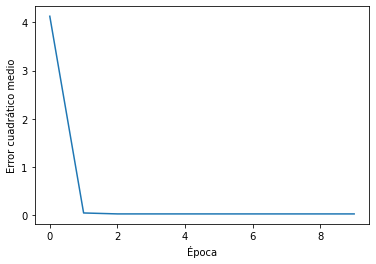

In [8]:
plt.plot(histgd)
plt.xlabel(u'Época')
plt.ylabel(u'Error cuadrático medio')
plt.show()

Visualizamos la curva ajustada.

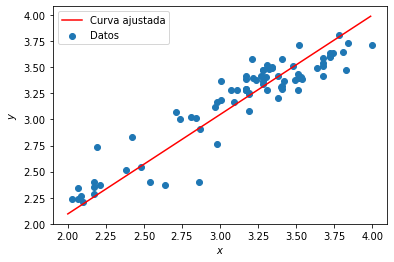

In [9]:
y_rango_gd = X_rango.T @ wgd + bgd

plt.scatter(X_ent[:, 0], y_ent[:, 0], label = 'Datos')
plt.plot(X_rango.T[:, 0], y_rango_gd[:, 0], 'r', label = 'Curva ajustada')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

In [10]:
n_epocas = 10
np.random.seed(42) # mismo valor inicial de peso que en GD
wsgd, bsgd, histsgd, histsgd_lotes = descenso_gradiente_estocastico(X_ent, 
                                                                    y_ent, 
                                                                    n_epocas = n_epocas,
                                                                    t_lote = 32, 
                                                                    tasa = 0.001)

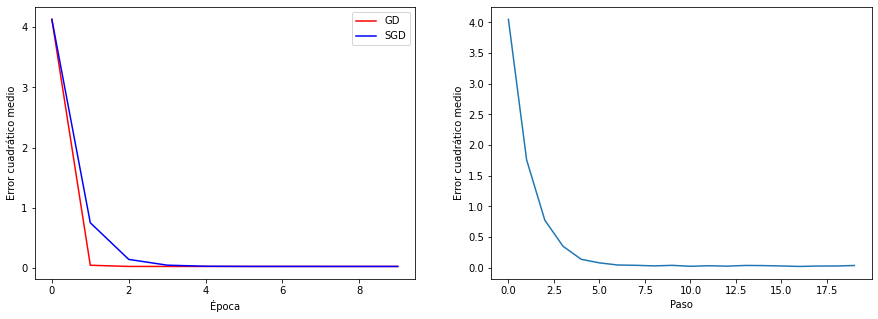

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(histgd, 'r', label='GD')
axs[0].plot(histsgd, 'b', label='SGD')
axs[0].set_xlabel(u'Época')
axs[0].set_ylabel(u'Error cuadrático medio')
axs[0].legend()

axs[1].plot(histsgd_lotes.flatten())
axs[1].set_xlabel(u'Paso')
axs[1].set_ylabel(u'Error cuadrático medio')

plt.show()

Visualizamos y comparamos el modelo con el del descenso por gradiente completo.

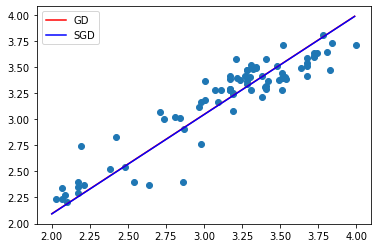

In [12]:
y_rango_sgd = X_rango.T @ wsgd + bsgd

plt.scatter(X_ent[:, 0], y_ent[:, 0])
plt.plot(X_rango.T[:, 0], y_rango_gd[:, 0], 'r', label='GD')
plt.plot(X_rango.T[:, 0], y_rango_sgd[:, 0], 'b', label='SGD')
plt.legend()
plt.show()

## Ejercicio
+ Programa y evalúa el algoritmo del descenso por gradiente para regresión lineal que minimice la siguiente función de error:

$$
E(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{2\cdot n} \sum_{i = 1} ^n \left(\hat{y^{(i)}} - y^{(i)}\right)^2
$$